In [1]:
# General Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from selenium import webdriver
import main
import seaborn as sns
import chromedriver_autoinstaller
from datetime import datetime
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch
from matplotlib.colors import to_rgba
import matplotlib as mpl
from collections import defaultdict

# Machine Learning
import scipy as sp
from scipy.spatial import distance
import sklearn
from sklearn.ensemble import RandomForestClassifier, IsolationForest
import sklearn.metrics as sk_metrics
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score , roc_curve, average_precision_score, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
import pickle
import xgboost as xgb
from xgboost import XGBClassifier, cv

In [2]:
chromedriver_autoinstaller.install()

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

## Example - For 1 Game
- To show the steps involved in the data preparation
- Then just generalise to a function

In [142]:
chromedriver_autoinstaller.install()

if __name__ == "__main__":
    driver = webdriver.Chrome()
    
# whoscored match centre url of the required match (Example: Barcelona vs Sevilla)
url = "https://www.whoscored.com/Matches/1640902/Live/England-Premier-League-2022-2023-Chelsea-Fulham"
match_data = main.getMatchData(driver, url, close_window=True)

# Match dataframe containing info about the match
matches_df = main.createMatchesDF(match_data)

# Events dataframe      
events_df = main.createEventsDF(match_data)

# match Id
matchId = match_data['matchId']

# Information about respective teams as dictionary
home_data = matches_df['home'][matchId]
away_data = matches_df['away'][matchId]
score = matches_df['score'][matchId]
score = ' ' + score.replace(':', '-') + ' '

home_name = home_data['name']
away_name = away_data['name']
date = match_data['startDate'].split('T')[0]
date_ = datetime.strptime(date, '%Y-%m-%d').date()
date_str = date_.strftime('%d/%m/%Y')

Region: England, League: Premier League, Season: 2022/2023, Match Id: 1640902


## Get Previous Events 
- To show origin of certain shots which aren't captured via Opta
- E.g. whether shot comes from a cross etc. 

In [143]:
events_df["passRecipient"] = events_df['playerName'].shift(-1)
events_df['teamRecipient'] = events_df['teamId'].shift(-1)
events_df['prevEvent'] = events_df['type'].shift(1)
events_df['shotLongPass'] = events_df['keyPassLong'].shift(1)
events_df['shotShortPass'] = events_df['keyPassShort'].shift(1)
events_df['shotCross'] = events_df['keyPassCross'].shift(1)
events_df['shotThroughBall'] = events_df['keyPassThroughball'].shift(1)
events_df['playerAssist'] = events_df['playerName'].shift(1)
events_df['prevTeam'] = events_df['teamId'].shift(1)


column_to_move = events_df.pop("passRecipient")
events_df.insert(29, "passRecipient", column_to_move)
column_to_move = events_df.pop("teamRecipient")
events_df.insert(27, "teamRecipient", column_to_move)
column_to_move = events_df.pop('prevEvent')
events_df.insert(11, "prevEvent", column_to_move)

## Data Reduction
- Need to keep certain columns related to shot situations/types etc.
- Also need to remove all penalties and own goals

In [144]:
feature_cols = ['id',
                'teamId',
                'prevTeam',
                'x', 
                'y', 
                'playerName', 
                'playerAssist',
                'minute', 
                'second',
                'type',
                'prevEvent',
                'isGoal',
                'shotRightFoot',
                'shotLeftFoot',
                'shotHead',
                'shotOpenPlay',
                'shotSetPiece',
                'shotCounter',
#                 'shotDirectCorner',
                'penaltyScored',
                'penaltyMissed',
                'goalOwn',
#                 'shotLongPass',
#                 'shotShortPass',
#                 'shotCross',
#                 'shotThroughBall',
                'bigChanceScored',
                'bigChanceMissed'
              ]

shot_types = ['SavedShot', 
              'MissedShots', 
              'Goal', 
              'ShotOnPost'
             ]


In [145]:
# To retrieve all shots during the game and columns we need
df_shots = events_df[events_df['type'].isin(shot_types)].reset_index(drop=True)[feature_cols]
df_shots


,id,teamId,prevTeam,x,y,playerName,playerAssist,minute,second,type,prevEvent,isGoal,shotRightFoot,shotLeftFoot,shotHead,shotOpenPlay,shotSetPiece,shotCounter,penaltyScored,penaltyMissed,goalOwn,bigChanceScored,bigChanceMissed
0,2.503408e+09,170,170.0,90.0,36.5,Bobby De Cordova-Reid,Kenny Tete,9,40.0,MissedShots,Pass,False,False,False,True,True,False,False,False,False,False,False,False
1,2.503417e+09,15,15.0,78.5,68.8,Mason Mount,Marc Cucurella,17,55.0,SavedShot,Pass,False,True,False,False,True,False,False,False,False,False,False,False
2,2.503423e+09,170,170.0,79.9,39.5,Andreas Pereira,João Palhinha,24,11.0,SavedShot,Pass,False,True,False,False,True,False,False,False,False,False,False,False
3,2.503430e+09,15,170.0,91.0,45.6,Kai Havertz,Tim Ream,31,14.0,MissedShots,BallTouch,False,True,False,False,True,False,False,False,False,False,False,True
4,2.503431e+09,15,15.0,81.3,54.4,Kai Havertz,Benoît Badiashile,32,52.0,MissedShots,Pass,False,False,True,False,True,False,False,False,False,False,False,False
5,2.503433e+09,15,15.0,88.0,29.7,Hakim Ziyech,Enzo Fernández,35,5.0,MissedShots,Pass,False,True,False,False,False,False,True,False,False,False,False,False
6,2.503440e+09,15,15.0,91.3,64.3,Kai Havertz,Hakim Ziyech,44,32.0,ShotOnPost,Pass,False,False,True,False,True,False,False,False,False,False,False,True
7,2.503453e+09,170,15.0,85.0,30.4,Willian,Conor Gallagher,45,15.0,SavedShot,Challenge,False,True,False,False,True,False,False,False,False,False,False,False
8,2.503463e+09,170,170.0,85.9,53.9,Andreas Pereira,Willian,58,45.0,SavedShot,Pass,False,True,False,False,True,False,False,False,False,False,False,False
9,2.503463e+09,170,15.0,80.6,68.4,João Palhinha,Conor Gallagher,58,49.0,MissedShots,Tackle,False,False,True,False,True,False,False,False,False,False,False,False


In [146]:
# To remove all pens and own goals 
df_shots = df_shots[(df_shots['penaltyScored'] == False) & 
                    (df_shots['penaltyMissed'] == False) &
                    (df_shots['goalOwn'] == False)
                   ]
# df_shots['shotTakeOn'] = df_shots['prevEvent'] == 'TakeOn'
# df_shots['shotDefensiveAction'] = df_shots['prevEvent'].isin(['Challenge', 'Tackle', 'Interception', 'Clearance',
#                                                               'BallRecovery', 'BlockedPass'])
df_shots

,id,teamId,prevTeam,x,y,playerName,playerAssist,minute,second,type,prevEvent,isGoal,shotRightFoot,shotLeftFoot,shotHead,shotOpenPlay,shotSetPiece,shotCounter,penaltyScored,penaltyMissed,goalOwn,bigChanceScored,bigChanceMissed
0,2.503408e+09,170,170.0,90.0,36.5,Bobby De Cordova-Reid,Kenny Tete,9,40.0,MissedShots,Pass,False,False,False,True,True,False,False,False,False,False,False,False
1,2.503417e+09,15,15.0,78.5,68.8,Mason Mount,Marc Cucurella,17,55.0,SavedShot,Pass,False,True,False,False,True,False,False,False,False,False,False,False
2,2.503423e+09,170,170.0,79.9,39.5,Andreas Pereira,João Palhinha,24,11.0,SavedShot,Pass,False,True,False,False,True,False,False,False,False,False,False,False
3,2.503430e+09,15,170.0,91.0,45.6,Kai Havertz,Tim Ream,31,14.0,MissedShots,BallTouch,False,True,False,False,True,False,False,False,False,False,False,True
4,2.503431e+09,15,15.0,81.3,54.4,Kai Havertz,Benoît Badiashile,32,52.0,MissedShots,Pass,False,False,True,False,True,False,False,False,False,False,False,False
5,2.503433e+09,15,15.0,88.0,29.7,Hakim Ziyech,Enzo Fernández,35,5.0,MissedShots,Pass,False,True,False,False,False,False,True,False,False,False,False,False
6,2.503440e+09,15,15.0,91.3,64.3,Kai Havertz,Hakim Ziyech,44,32.0,ShotOnPost,Pass,False,False,True,False,True,False,False,False,False,False,False,True
7,2.503453e+09,170,15.0,85.0,30.4,Willian,Conor Gallagher,45,15.0,SavedShot,Challenge,False,True,False,False,True,False,False,False,False,False,False,False
8,2.503463e+09,170,170.0,85.9,53.9,Andreas Pereira,Willian,58,45.0,SavedShot,Pass,False,True,False,False,True,False,False,False,False,False,False,False
9,2.503463e+09,170,15.0,80.6,68.4,João Palhinha,Conor Gallagher,58,49.0,MissedShots,Tackle,False,False,True,False,True,False,False,False,False,False,False,False


## Data Engineering
- Need to add key metrics such as distance and angle to the goal

In [147]:
pitch_length_x = 100
pitch_length_y = 100
df_shots['distance_to_goal'] = np.sqrt(((pitch_length_x - df_shots['x'])**2 + 
                                (pitch_length_y - df_shots['y'])**2))
df_shots['distance_to_center'] = abs(df_shots['y'] - pitch_length_y/2)
df_shots['angle'] = np.absolute(np.degrees(np.arctan((abs((pitch_length_y/2) - df_shots['y'])) 
                                                     / (pitch_length_x - df_shots['x']))))

# Now remove prevEvent, ownGoal and penalty cols
df_shots = df_shots.drop(['prevEvent', 'penaltyScored', 'penaltyMissed', 'goalOwn', 'type'], axis=1)
df_shots_game = df_shots.copy()
df_shots_game

# Add Big Chance Column
df_shots_game['bigChance'] = df_shots_game['bigChanceMissed'] | df_shots_game['bigChanceScored']
df_shots_game = df_shots_game.drop(['bigChanceMissed', 'bigChanceScored'], axis=1)
df_shots_game

,id,teamId,prevTeam,x,y,playerName,playerAssist,minute,second,isGoal,shotRightFoot,shotLeftFoot,shotHead,shotOpenPlay,shotSetPiece,shotCounter,distance_to_goal,distance_to_center,angle,bigChance
0,2.503408e+09,170,170.0,90.0,36.5,Bobby De Cordova-Reid,Kenny Tete,9,40.0,False,False,False,True,True,False,False,64.282579,13.5,53.471145,False
1,2.503417e+09,15,15.0,78.5,68.8,Mason Mount,Marc Cucurella,17,55.0,False,True,False,False,True,False,False,37.890500,18.8,41.167053,False
2,2.503423e+09,170,170.0,79.9,39.5,Andreas Pereira,João Palhinha,24,11.0,False,True,False,False,True,False,False,63.751549,10.5,27.582029,False
3,2.503430e+09,15,170.0,91.0,45.6,Kai Havertz,Tim Ream,31,14.0,False,True,False,False,True,False,False,55.139460,4.4,26.053495,True
4,2.503431e+09,15,15.0,81.3,54.4,Kai Havertz,Benoît Badiashile,32,52.0,False,False,True,False,True,False,False,49.285393,4.4,13.240520,False
5,2.503433e+09,15,15.0,88.0,29.7,Hakim Ziyech,Enzo Fernández,35,5.0,False,True,False,False,False,False,True,71.316828,20.3,59.411265,False
6,2.503440e+09,15,15.0,91.3,64.3,Kai Havertz,Hakim Ziyech,44,32.0,False,False,True,False,True,False,False,36.744796,14.3,58.684020,True
7,2.503453e+09,170,15.0,85.0,30.4,Willian,Conor Gallagher,45,15.0,False,True,False,False,True,False,False,71.198034,19.6,52.572949,False
8,2.503463e+09,170,170.0,85.9,53.9,Andreas Pereira,Willian,58,45.0,False,True,False,False,True,False,False,48.208091,3.9,15.461218,False
9,2.503463e+09,170,15.0,80.6,68.4,João Palhinha,Conor Gallagher,58,49.0,False,False,True,False,True,False,False,37.079914,18.4,43.484592,False


In [148]:
# Convert categorical True/False cols to 1/0
cat_cols = ['shotRightFoot',
            'shotLeftFoot',
            'shotHead',
            'shotOpenPlay',
            'shotSetPiece',
            'shotCounter',
#             'shotDirectCorner',
#             'shotLongPass',
#             'shotShortPass',
#             'shotCross',
#             'shotThroughBall',
#             'shotTakeOn', 
#             'shotDefensiveAction'
            'bigChance'
           ]

# In retrospect, decided to remove shots from Counters and Defensive Actions since it seemed to overfit the model

df_shots_game[cat_cols] *= 1
df_shots_game.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 0 to 21
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  22 non-null     float64
 1   teamId              22 non-null     int64  
 2   prevTeam            22 non-null     float64
 3   x                   22 non-null     float64
 4   y                   22 non-null     float64
 5   playerName          22 non-null     object 
 6   playerAssist        22 non-null     object 
 7   minute              22 non-null     int64  
 8   second              22 non-null     float64
 9   isGoal              22 non-null     bool   
 10  shotRightFoot       22 non-null     int64  
 11  shotLeftFoot        22 non-null     int64  
 12  shotHead            22 non-null     int64  
 13  shotOpenPlay        22 non-null     int64  
 14  shotSetPiece        22 non-null     int64  
 15  shotCounter         22 non-null     int64  
 16  distance_t

In [149]:
 obj_cols = [
#             'shotLongPass',
#             'shotShortPass',
#             'shotCross',
#             'shotThroughBall',
 ]
    
for col in obj_cols:
    df_shots_game[col] = pd.to_numeric(df_shots_game[col])
    
df_shots_game.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 0 to 21
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  22 non-null     float64
 1   teamId              22 non-null     int64  
 2   prevTeam            22 non-null     float64
 3   x                   22 non-null     float64
 4   y                   22 non-null     float64
 5   playerName          22 non-null     object 
 6   playerAssist        22 non-null     object 
 7   minute              22 non-null     int64  
 8   second              22 non-null     float64
 9   isGoal              22 non-null     bool   
 10  shotRightFoot       22 non-null     int64  
 11  shotLeftFoot        22 non-null     int64  
 12  shotHead            22 non-null     int64  
 13  shotOpenPlay        22 non-null     int64  
 14  shotSetPiece        22 non-null     int64  
 15  shotCounter         22 non-null     int64  
 16  distance_t

In [150]:
X_sg = df_shots_game.iloc[:, 10:]
Y_sg = df_shots_game['isGoal']
Y_sg


0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
Name: isGoal, dtype: bool

## Generalised Function of the above 

In [151]:
feature_cols = ['id',
                'teamId',
                'prevTeam',
                'x', 
                'y',
                'playerName', 
                'playerAssist',
                'minute', 
                'second',
                'type',
                'prevEvent',
                'isGoal',
                'shotRightFoot',
                'shotLeftFoot',
                'shotHead',
                'shotOpenPlay',
                'shotSetPiece',
                'shotCounter', 
#                 'shotDirectCorner',
                'penaltyScored',
                'penaltyMissed',
                'goalOwn',
#                 'shotLongPass',
#                 'shotShortPass',
#                 'shotCross',
#                 'shotThroughBall',
                'bigChanceScored',
                'bigChanceMissed'
              ]

shot_types = ['SavedShot', 
              'MissedShots', 
              'Goal', 
              'ShotOnPost'
             ]


def shotData(df):
    df["passRecipient"] = df['playerName'].shift(-1)
    df['teamRecipient'] = df['teamId'].shift(-1)
    df['prevEvent'] = df['type'].shift(1)
    df['shotLongPass'] = df['keyPassLong'].shift(1)
    df['shotShortPass'] = df['keyPassShort'].shift(1)
    df['shotCross'] = df['keyPassCross'].shift(1)
    df['shotThroughBall'] = df['keyPassThroughball'].shift(1)
    df['playerAssist'] = df['playerName'].shift(1)
    df['prevTeam'] = df['teamId'].shift(1)

    column_to_move = df.pop("passRecipient")
    df.insert(29, "passRecipient", column_to_move)
    column_to_move = df.pop("teamRecipient")
    df.insert(27, "teamRecipient", column_to_move)
    column_to_move = df.pop('prevEvent')
    df.insert(11, "prevEvent", column_to_move)

    df_shots = df[df['type'].isin(shot_types)].reset_index(drop=True)[feature_cols]

    df_shots = df_shots[(df_shots['penaltyScored'] == False) & 
                        (df_shots['penaltyMissed'] == False) &
                        (df_shots['goalOwn'] == False)
                       ]
#     df_shots['shotTakeOn'] = df_shots['prevEvent'] == 'TakeOn'
#     df_shots['shotDefensiveAction'] = df_shots['prevEvent'].isin(['Challenge', 'Tackle', 'Interception', 'Clearance',
#                                                                   'BallRecovery', 'BlockedPass'])

    df_shots['distance_to_goal'] = np.sqrt(((pitch_length_x - df_shots['x'])**2 + 
                                    (pitch_length_y - df_shots['y'])**2))
    df_shots['distance_to_center'] = abs(df_shots['y'] - pitch_length_y/2)
    df_shots['angle'] = np.absolute(np.degrees(np.arctan((abs((pitch_length_y/2) - df_shots['y'])) 
                                                         / (pitch_length_x - df_shots['x']))))


    df_shots = df_shots.drop(['prevEvent', 'penaltyScored', 'penaltyMissed', 'goalOwn', 'type'], axis=1)
    
    # Add Big Chance Column
    df_shots['bigChance'] = df_shots['bigChanceMissed'] | df_shots['bigChanceScored']
    df_shots = df_shots.drop(['bigChanceMissed', 'bigChanceScored'], axis=1)

    cat_cols = ['shotRightFoot',
            'shotLeftFoot',
            'shotHead',
            'shotOpenPlay',
            'shotSetPiece',
#             'shotDirectCorner',
            'shotCounter',
#             'shotLongPass',
#             'shotShortPass',
#             'shotCross',
#             'shotThroughBall',
#             'shotTakeOn', 
#             'shotDefensiveAction',
            'bigChance'
           ]
    df_shots[cat_cols] *= 1
    
    obj_cols = [
#             'shotLongPass',
#             'shotShortPass',
#             'shotCross',
#             'shotThroughBall',
             ]
    
    for col in obj_cols:
        df_shots[col] = pd.to_numeric(df_shots[col])
    

    return df_shots 

##  Import Datsets and split into training sets
- Using the logic above, we import our datasets containing shot locations and reduce based on the above criteria
- Using match event data for top 5 leagues for years 2019-2022

In [152]:
leagues = ['bl', 'll', 'pl', 'sa', 'lu']
years = ['1920', '2021', '2122']
halves = ['FirstHalf', 'SecondHalf']

names = []
for league in leagues:
    for year in years:
        for half in halves:
            name = league + '_' + year + '_' + half + '.csv'
            names.append(name)

In [153]:
shots = pd.DataFrame()

for name in names:
    df = pd.read_csv('Datasets/' + name).iloc[:, 1:]
    
    df = shotData(df)
    
    shots = pd.concat([shots, df], axis = 0)
    

In [154]:
shots = shots.drop_duplicates().reset_index(drop=True)
shots

,id,teamId,prevTeam,x,y,playerName,playerAssist,minute,second,isGoal,shotRightFoot,shotLeftFoot,shotHead,shotOpenPlay,shotSetPiece,shotCounter,distance_to_goal,distance_to_center,angle,bigChance
0,1.684720e+09,37,37.0,78.3,54.3,Thiago,Serge Gnabry,2,58.0,False,1,0,0,1,0,0,50.590315,4.3,11.208344,0
1,7.530462e+08,37,37.0,81.5,43.1,Thomas Müller,Serge Gnabry,6,58.0,False,1,0,0,1,0,0,59.831931,6.9,20.454156,0
2,1.947652e+09,47,47.0,80.5,61.5,Vedad Ibisevic,Marko Grujic,8,9.0,False,1,0,0,1,0,0,43.156691,11.5,30.529706,0
3,9.657038e+08,47,47.0,91.5,60.8,Vedad Ibisevic,Ondrej Duda,12,34.0,False,1,0,0,1,0,0,40.110971,10.8,51.795944,0
4,1.911919e+09,37,37.0,93.7,39.4,Thomas Müller,Thomas Müller,16,55.0,False,0,0,1,0,1,0,60.926595,10.6,59.275307,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129851,2.419211e+09,145,145.0,87.9,32.8,Sada Thioub,Mahdi Camara,81,22.0,False,0,1,0,0,1,0,68.280671,17.2,54.874059,0
129852,2.419214e+09,613,145.0,82.4,78.6,Andy Delort,Harold-Desty Moukoudi,85,3.0,False,1,0,0,0,1,0,27.707761,28.6,58.392498,0
129853,2.419216e+09,145,145.0,89.1,56.0,Adil Aouchiche,Mahdi Camara,86,23.0,False,1,0,0,1,0,0,45.330012,6.0,28.830968,1
129854,2.419219e+09,613,613.0,83.1,48.1,Andy Delort,Calvin Stengs,90,25.0,False,1,0,0,1,0,0,54.582232,1.9,6.414602,0


In [158]:
X = shots.iloc[:, 10:]
Y = shots['isGoal']
X

,shotRightFoot,shotLeftFoot,shotHead,shotOpenPlay,shotSetPiece,shotCounter,distance_to_goal,distance_to_center,angle,bigChance
0,1,0,0,1,0,0,50.590315,4.3,11.208344,0
1,1,0,0,1,0,0,59.831931,6.9,20.454156,0
2,1,0,0,1,0,0,43.156691,11.5,30.529706,0
3,1,0,0,1,0,0,40.110971,10.8,51.795944,0
4,0,0,1,0,1,0,60.926595,10.6,59.275307,0
...,...,...,...,...,...,...,...,...,...,...
129851,0,1,0,0,1,0,68.280671,17.2,54.874059,0
129852,1,0,0,0,1,0,27.707761,28.6,58.392498,0
129853,1,0,0,1,0,0,45.330012,6.0,28.830968,1
129854,1,0,0,1,0,0,54.582232,1.9,6.414602,0


In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [160]:
data_dmatrix = xgb.DMatrix(data=X, label=Y)

## Train Model 
- Using XGBoost - a boosting model.
- In general, boosting refers to any Ensemble method that can combine several weak learners into a strong learner. General idea is to train predictors sequentially.
- Gradient Boosting works by sequentially adding predictors to an ensemble, each one trying to correct its predecessor. The method tries to fit the new predictor to the residual errors made by the previous predictor. 
- XGBoost is an optimised implementation of Gradient Boosting. 

In [161]:
# Initial Parameters
params = {'base_score' : 0.5, 
          'gamma' : 0, 
          'max_depth' : 6,
          'min_child_weight' : 1, 
          'eta' : 0.3, 
          'subsample' : 1, 
          'colsample_bytree' : 1, 
          'objective': 'binary:logistic'}

# Instantiate the classifier
xgb_clf = XGBClassifier(**params)

# Fit classifier to training data
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.3,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

In [162]:
y_pred = xgb_clf.predict_proba(X_test)

df_pred = pd.DataFrame(y_pred, columns = ['prob_no_goal', 'prob_goal'])
df_pred = pd.merge(X_test, df_pred, left_index=True, right_index=True)
df_pred

,shotRightFoot,shotLeftFoot,shotHead,shotOpenPlay,shotSetPiece,shotCounter,distance_to_goal,distance_to_center,angle,bigChance,prob_no_goal,prob_goal
6847,1,0,0,0,1,0,25.904440,24.8,76.399457,0,0.962072,0.037928
36934,1,0,0,0,1,0,54.256060,2.6,5.624628,0,0.920901,0.079099
7230,1,0,0,1,0,0,73.976010,23.8,77.905243,0,0.911437,0.088563
2502,0,1,0,0,0,1,44.893875,6.5,30.352625,1,0.963733,0.036267
16670,0,0,1,1,0,0,60.557741,10.0,50.648247,0,0.928567,0.071433
...,...,...,...,...,...,...,...,...,...,...,...,...
32539,0,1,0,1,0,0,60.982375,6.6,16.211731,0,0.992836,0.007164
26122,1,0,0,0,0,1,44.576451,5.9,42.229784,0,0.765588,0.234412
15278,0,0,0,1,0,0,47.681967,3.1,19.822465,0,0.984399,0.015601
32347,0,1,0,1,0,0,60.495372,7.5,21.748845,0,0.938075,0.061925


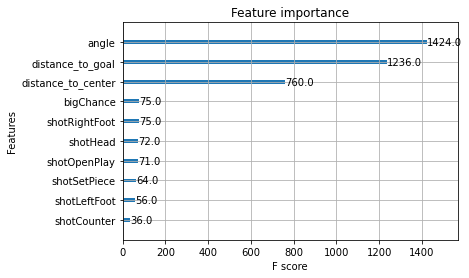

<Figure size 1440x1080 with 0 Axes>

In [163]:
xgb.plot_importance(xgb_clf,
                    ax=plt.gca()
                   )
plt.figure(figsize=(20, 15))
plt.show()

In [164]:
from sklearn.metrics import recall_score, auc
from sklearn.base import clone

def calculate_roc_auc(y_true, y_prob):
    tprs = []
    fprs = []
    num_points = 100
    thresholds = np.linspace(0,1,num_points+1)
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        tpr = recall_score(y_true, y_pred, pos_label=1)
        fpr = 1 - recall_score(y_true, y_pred, pos_label=0)
        tprs.append(tpr)
        fprs.append(fpr)
    
    auc_score = auc(fprs, tprs)
    
    return auc_score


In [165]:
calculate_roc_auc(np.ravel(y_test)*1, y_pred[:,1])

0.7957265215826479

In [166]:
# Compute the log loss
pred = y_pred[:,1]
test = np.ravel(y_test)*1
print(f'Log Loss of model: {sk_metrics.log_loss(test, pred):.5f}')

Log Loss of model: 0.26122


In [167]:
# Compute the AUC of initial model
print(f'ROC AUC of our model: {sk_metrics.roc_auc_score(test, pred)*100:.2f}%')

ROC AUC of our model: 79.62%


## Test on game earlier

In [168]:
data = shotData(events_df)
X_game = data.iloc[:, 10:]
Y_game = data['isGoal']

In [169]:
y_pred_game = xgb_clf.predict_proba(X_game)
df_pred_game = pd.DataFrame(y_pred_game, columns = ['prob_no_goal', 'prob_goal'])
df_pred_game = pd.merge(data, df_pred_game, left_index=True, right_index=True)

for i in range(len(df_pred_game)):
    if (int(df_pred_game['teamId'][i]) != int(df_pred_game['prevTeam'][i])) or (df_pred_game['playerName'][i] == df_pred_game['playerAssist'][i]):
        df_pred_game['playerAssist'][i] = None
        
df_pred_game[['playerName','playerAssist', 'prob_goal']]

,playerName,playerAssist,prob_goal
0,Bobby De Cordova-Reid,Kenny Tete,0.027340
1,Mason Mount,Marc Cucurella,0.013392
2,Andreas Pereira,João Palhinha,0.024755
3,Kai Havertz,None,0.509998
4,Kai Havertz,Benoît Badiashile,0.095483
5,Hakim Ziyech,Enzo Fernández,0.014011
6,Kai Havertz,Hakim Ziyech,0.354188
7,Willian,None,0.040157
8,Andreas Pereira,Willian,0.078473
9,João Palhinha,None,0.024118


In [170]:
df_pred_game.groupby(['teamId'])['prob_goal'].sum()

teamId
15     1.629237
170    0.440656
Name: prob_goal, dtype: float32

Contrasts to:
- 1.3 vs 0.6 (fbref)
- 1.33 vs 0.65 (fotmob)
- 1.41 vs 0.49 (Understat)
- 1.5 vs 0.4 (Caley Graphics)
- 1.05 vs 0.45 (McLach Bot)

So all in all seems reasonable

## Test on another game

In [171]:
chromedriver_autoinstaller.install()

if __name__ == "__main__":
    driver = webdriver.Chrome()
    
# whoscored match centre url of the required match (Example: Barcelona vs Sevilla)
url = "https://www.whoscored.com/Matches/1640867/Live/England-Premier-League-2022-2023-Chelsea-Crystal-Palace"
match_data = main.getMatchData(driver, url, close_window=True)

# Match dataframe containing info about the match
matches_df = main.createMatchesDF(match_data)

# Events dataframe      
events_df = main.createEventsDF(match_data)

# match Id
matchId = match_data['matchId']

Region: England, League: Premier League, Season: 2022/2023, Match Id: 1640867


In [172]:
data = shotData(events_df)
X_game = data.iloc[:, 10:]
Y_game = data['isGoal']

In [173]:
y_pred_game = xgb_clf.predict_proba(X_game)
df_pred_game = pd.DataFrame(y_pred_game, columns = ['prob_no_goal', 'prob_goal'])
df_pred_game = pd.merge(data, df_pred_game, left_index=True, right_index=True)

for i in range(len(df_pred_game)):
    if (int(df_pred_game['teamId'][i]) != int(df_pred_game['prevTeam'][i])) or (df_pred_game['playerName'][i] == df_pred_game['playerAssist'][i]):
        df_pred_game['playerAssist'][i] = None
        
df_pred_game[['playerName','playerAssist', 'prob_goal']]

,playerName,playerAssist,prob_goal
0,Hakim Ziyech,None,0.024077
1,Tyrick Mitchell,None,0.374911
2,Michael Olise,Cheick Oumar Doucouré,0.042675
3,Eberechi Eze,None,0.056593
4,Kai Havertz,None,0.291548
5,Carney Chukwuemeka,Conor Gallagher,0.041653
6,Lewis Hall,Conor Gallagher,0.088552
7,Mason Mount,None,0.057437
8,Jeffrey Schlupp,None,0.082646
9,Hakim Ziyech,None,0.107059


In [175]:
df_pred_game.groupby(['teamId'])['prob_goal'].sum()

teamId
15     1.775866
162    0.759175
Name: prob_goal, dtype: float32

Contrasts to:
- 1.5 vs 0.7 (fbref)
- 1.5 vs 0.7 (fotmob)
- 2.13 vs 0.84 (understat)

## Save Model for further use 

In [176]:
filename = 'xgModel_XGBoost22.sav'
pickle.dump(xgb_clf, open(filename, 'wb'))

## And then to use, simply:

In [177]:
chromedriver_autoinstaller.install()

if __name__ == "__main__":
    driver = webdriver.Chrome()
    
# whoscored match centre url of the required match (Example: Barcelona vs Sevilla)
url = "https://www.whoscored.com/Matches/1640888/Live/England-Premier-League-2022-2023-Liverpool-Chelsea"
match_data = main.getMatchData(driver, url, close_window=True)

# Match dataframe containing info about the match
matches_df = main.createMatchesDF(match_data)

# Events dataframe      
events_df = main.createEventsDF(match_data)

# match Id
matchId = match_data['matchId']

Region: England, League: Premier League, Season: 2022/2023, Match Id: 1640888


In [178]:
data = shotData(events_df)
X_game = data.iloc[:, 10:]
Y_game = data['isGoal']

In [179]:
xg_model = pickle.load(open(filename, 'rb'))

In [180]:
y_pred_game = xg_model.predict_proba(X_game)
df_pred_game = pd.DataFrame(y_pred_game, columns = ['prob_no_goal', 'prob_goal'])
df_pred_game = pd.merge(data, df_pred_game, left_index=True, right_index=True)

for i in range(len(df_pred_game)):
    if (int(df_pred_game['teamId'][i]) != int(df_pred_game['prevTeam'][i])) or (df_pred_game['playerName'][i] == df_pred_game['playerAssist'][i]):
        df_pred_game['playerAssist'][i] = None
        
df_pred_game[['playerName','playerAssist', 'prob_goal']]

,playerName,playerAssist,prob_goal
0,Thiago Silva,Benoît Badiashile,0.274247
1,Cody Gakpo,Mohamed Salah,0.087907
2,Kai Havertz,Thiago Silva,0.016698
3,Cody Gakpo,None,0.086251
4,Lewis Hall,Mason Mount,0.017112
5,Conor Gallagher,Kai Havertz,0.067237
6,Benoît Badiashile,Hakim Ziyech,0.315755
7,Kai Havertz,Hakim Ziyech,0.123511
8,Cody Gakpo,None,0.045887
9,Thiago,None,0.071695


In [141]:
df_pred_game.groupby(['teamId'])['prob_goal'].sum()

teamId
15    1.635367
26    0.903127
Name: prob_goal, dtype: float32